<a href="https://colab.research.google.com/github/robert-shepherd/fpl/blob/main/Project_3_5_lasso_regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lasso regression model


---

The purpose of this script is to develop the lasso regression model

Data sources:
* Data post feature engineering:  https://raw.githubusercontent.com/robert-shepherd/fpl/main/fpl_features.csv


In [ ]:
# Loading libraries
import pandas as pd
import pickle
import numpy as np
import scipy.stats as stats
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# Model libraries
from sklearn.linear_model import Lasso

# Import measures
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

## Setup

In [ ]:
# Reading in files from static output
X_train_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/X_train.csv'
X_test_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/X_test.csv'
Y_train_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/Y_train.csv'
Y_test_url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/Y_test.csv'

X_train = pd.read_csv(X_train_url)
X_test = pd.read_csv(X_test_url)
Y_train = pd.read_csv(Y_train_url,squeeze=True)
Y_test = pd.read_csv(Y_test_url,squeeze=True)

print('X_train      : ',X_train.shape)
print('X_test       : ',X_test.shape)
print('Y_train      : ',Y_train.shape)
print('Y_test       : ',Y_test.shape)

X_train      :  (40388, 40)
X_test       :  (10098, 40)
Y_train      :  (40388,)
Y_test       :  (10098,)


In [ ]:
# Creating a copy with missing values removed
train_na = X_train.isnull().any(axis=1)
test_na = X_test.isnull().any(axis=1)

X_train_no_na = X_train[~train_na]
Y_train_no_na = Y_train[~train_na]

X_test_no_na = X_test[~test_na]
Y_test_no_na = Y_test[~test_na]

print('X_train_no_na      : ',X_train_no_na.shape)
print('X_test_no_na       : ',X_test_no_na.shape)
print('Y_train_no_na      : ',Y_train_no_na.shape)
print('Y_test_no_na       : ',Y_test_no_na.shape)

X_train_no_na      :  (32698, 40)
X_test_no_na       :  (8195, 40)
Y_train_no_na      :  (32698,)
Y_test_no_na       :  (8195,)


## Default Lasso regression model


In [ ]:
# Training default Lasso model
lasso = Lasso(normalize=True)
lasso.fit(X_train_no_na,Y_train_no_na)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [ ]:
# Predicting on test
y_pred = lasso.predict(X_test_no_na)

In [ ]:
# Checking min/max prediction
min_pred = min(y_pred)
max_pred = max(y_pred)
print("Min prediction: {}".format(min_pred))
print("Max prediction: {}".format(max_pred))

Min prediction: 1.4166921524252247
Max prediction: 1.4166921524252247


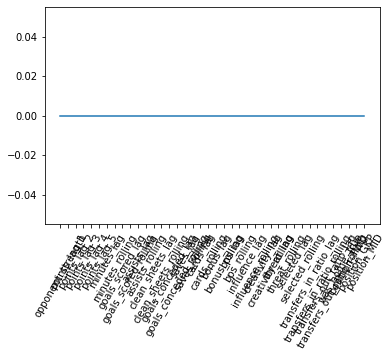

In [ ]:
# Plot coefficients
lasso_coef = lasso.coef_
df_columns = X_test_no_na.columns

plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=60)
#plt.margins(0.02)
plt.show()

# All coefficients set to 0

## Evaluating bias/variance tradeoff


In [ ]:
# Checking 10 fold cross validation error
MSE_CV_scores = cross_val_score(lasso, X_train_no_na, Y_train_no_na, cv=10, 
                       scoring='neg_mean_squared_error',
                       n_jobs=-1)

cv_mse = abs(MSE_CV_scores.mean())

print("CV MSE: {}".format(cv_mse))

CV MSE: 6.527112984750157


In [ ]:
# Checking test MSE
test_mse = mean_squared_error(Y_test_no_na, y_pred)
print("Test MSE: {}".format(test_mse))

Test MSE: 6.366269097205641


In [ ]:
# Checking training MSE
y_pred_train = lasso.predict(X_train_no_na)
train_mse = mean_squared_error(Y_train_no_na, y_pred_train)
print("Train MSE: {}".format(train_mse))

Train MSE: 6.526318717450802


## Optimising alpha selection

In [ ]:
# Setup
lasso = Lasso(normalize=True)

alpha_space = np.logspace(-4, 0, 50)
lasso_scores = []
lasso_scores_std = []

In [ ]:
# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: lasso.alpha
    lasso.alpha = alpha
    
    # Perform 10-fold CV: lasso_cv_scores
    lasso_cv_scores = cross_val_score(lasso,X_train_no_na,Y_train_no_na,cv=8)
    
    # Append the mean of lasso_cv_scores to lasso_scores
    lasso_scores.append(np.mean(lasso_cv_scores))
    
    # Append the std of lasso_cv_scores to lasso_scores_std
    lasso_scores_std.append(np.std(lasso_cv_scores))

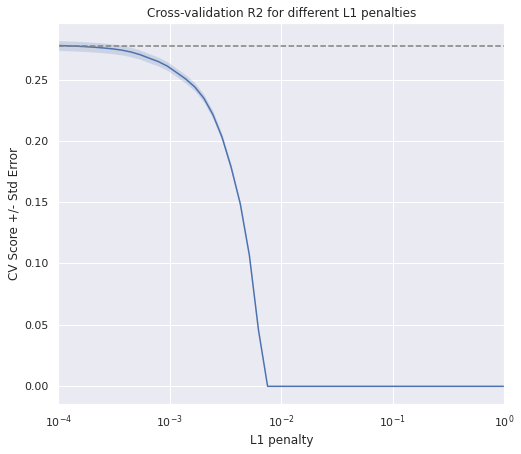

In [ ]:
# Display plot
sns.set()
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(1,1,1)
plt.plot(alpha_space, lasso_scores)

std_error = lasso_scores_std / np.sqrt(10)

ax.fill_between(alpha_space, lasso_scores + std_error, lasso_scores - std_error, alpha=0.2)
ax.set_ylabel('CV Score +/- Std Error')
ax.set_xlabel('L1 penalty')
ax.axhline(np.max(lasso_scores), linestyle='--', color='.5')
ax.set_xlim([alpha_space[0], alpha_space[-1]])
ax.set_xscale('log')
plt.title("Cross-validation R2 for different L1 penalties")
plt.show()

In [ ]:
# Using grid search to identify the optimum alpha level
lasso = Lasso(normalize=True)
param_grid = {'alpha': alpha_space}

gm_cv = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=8)

gm_cv.fit(X_train_no_na,Y_train_no_na)

y_pred = gm_cv.predict(X_test_no_na)
r2 = gm_cv.score(X_test_no_na, Y_test_no_na)
mse = mean_squared_error(Y_test_no_na, y_pred)
print("Lasso best CV score: {}".format(gm_cv.best_score_))
print("Tuned Lasso l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned Lasso R squared: {}".format(r2))
print("Tuned Lasso MSE: {}".format(mse))


Lasso best CV score: 0.2778368492695011
Tuned Lasso l1 ratio: {'alpha': 0.0001}
Tuned Lasso R squared: 0.2513763887143101
Tuned Lasso MSE: 4.765933864316354


## Understanding feature importance

In [ ]:
# Training Lasso model
lasso = Lasso(normalize=True,alpha=0.0001)
lasso.fit(X_train_no_na,Y_train_no_na)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
# Checking which variables have the largest coefficients
lasso_coef = lasso.coef_
df_columns = X_test_no_na.columns

coef_df = pd.DataFrame(df_columns,columns=['feature'])
coef_df['coefficients'] = lasso_coef
coef_df['coefficients_abs'] = abs(lasso_coef)

In [ ]:
# Checking which coefficients were reduced to 0
coef_df[coef_df.coefficients==0]

,feature,coefficients,coefficients_abs
8,goals_scored_lag,-0.0,0.0
9,goals_scored_rolling,0.0,0.0
10,assists_lag,-0.0,0.0
12,clean_sheets_lag,0.0,0.0
14,goals_conceded_lag,-0.0,0.0
15,goals_conceded_rolling,-0.0,0.0
19,cards_rolling,-0.0,0.0
22,bps_lag,0.0,0.0
23,bps_rolling,0.0,0.0
24,influence_lag,-0.0,0.0


In [ ]:
# Checking which coefficients were reduced to 0
removed_variables = df_columns[lasso_coef == 0]
print(removed_variables)

Index(['goals_scored_lag', 'goals_scored_rolling', 'assists_lag',
       'clean_sheets_lag', 'goals_conceded_lag', 'goals_conceded_rolling',
       'cards_rolling', 'bps_lag', 'bps_rolling', 'influence_lag',
       'influence_rolling', 'creativity_lag', 'selected_lag',
       'transfers_in_ratio_lag', 'transfers_in_ratio_rolling',
       'transfers_out_ratio_lag', 'position_MID'],
      dtype='object')


In [ ]:
# Viewing kept variables
kept_variables = df_columns[abs(lasso_coef) > 0]
print(kept_variables)

Index(['opponent_strength', 'points_lag_1', 'points_lag_2', 'points_lag_3',
       'points_lag_4', 'points_lag_5', 'minutes_lag', 'minutes_rolling',
       'assists_rolling', 'clean_sheets_rolling', 'saves_lag', 'saves_rolling',
       'cards_lag', 'bonus_lag', 'bonus_rolling', 'creativity_rolling',
       'threat_lag', 'threat_rolling', 'selected_rolling',
       'transfers_out_ratio_rolling', 'was_home_True', 'position_FWD',
       'position_GKP'],
      dtype='object')


In [ ]:
# Checking which variables have the largest coefficients
coef_df[abs(lasso_coef)>0].sort_values(by=['coefficients_abs'],ascending=False).head(20)

,feature,coefficients,coefficients_abs
11,assists_rolling,0.319230,0.319230
13,clean_sheets_rolling,0.221141,0.221141
17,saves_rolling,0.213351,0.213351
0,opponent_strength,-0.195222,0.195222
36,was_home_True,0.185691,0.185691
18,cards_lag,-0.132064,0.132064
35,transfers_out_ratio_rolling,0.118174,0.118174
38,position_GKP,-0.084546,0.084546
1,points_lag_1,0.049371,0.049371
21,bonus_rolling,-0.044904,0.044904


In [ ]:
# Setting default Seaborn style
sns.set(rc={'figure.figsize':(10,8)})

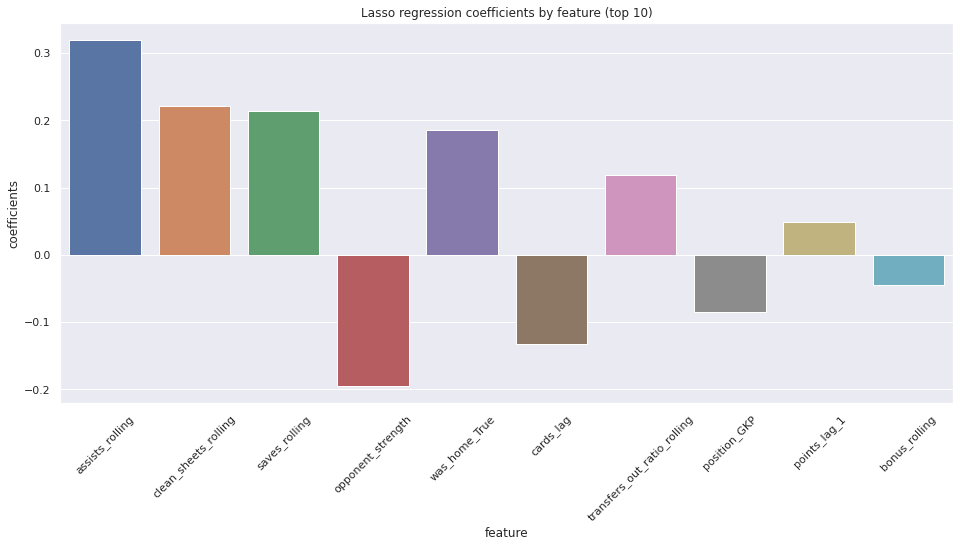

In [ ]:
# Plot coefficients
top_10_features = coef_df.sort_values(by=['coefficients_abs'],ascending=False).head(10)
plt.figure(figsize=(16,7))
plt.xticks(rotation=45) 
sns.barplot(x='feature', y='coefficients',data=top_10_features)
plt.title('Lasso regression coefficients by feature (top 10)')
plt.show()